In [11]:
import time
import warnings
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (accuracy_score, f1_score, precision_score, recall_score,
                           precision_recall_curve, auc, confusion_matrix, 
                           classification_report)
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
import os
import json

warnings.filterwarnings("ignore")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Running on", DEVICE)


Running on cuda


In [12]:
# =============================================================================
# Data Loading and Preprocessing (Following PDF Guidelines)
# =============================================================================

def load_data(path="medical_appointment_no_show.csv"):
    """Load and preprocess medical appointment data according to PDF specifications"""
    df = pd.read_csv(path)
    
    # Convert target (No-show: No=0, Yes=1)
    df['No-show'] = df['No-show'].map({'No': 0, 'Yes': 1})
    
    # Parse dates
    df['ScheduledDay'] = pd.to_datetime(df['ScheduledDay'])
    df['AppointmentDay'] = pd.to_datetime(df['AppointmentDay'])
    
    # Feature engineering
    df['Wait_Days'] = (df['AppointmentDay'] - df['ScheduledDay']).dt.days.clip(lower=0)
    df['Is_Weekday'] = df['AppointmentDay'].dt.weekday < 5
    
    # One-hot encode categorical features
    cat_cols = ['Gender', 'Neighbourhood']
    ohe = OneHotEncoder(sparse_output=False, drop='first')
    
    cat_encoded = ohe.fit_transform(df[cat_cols])
    cat_feature_names = ohe.get_feature_names_out(cat_cols)
    cat_df = pd.DataFrame(cat_encoded, columns=cat_feature_names)
    
    # Select numeric features
    num_cols = ['Age', 'Scholarship', 'Hipertension', 'Diabetes',
                'Alcoholism', 'Handcap', 'SMS_received', 'Wait_Days', 'Is_Weekday']
    
    # Combine features
    final_df = pd.concat([df[num_cols].reset_index(drop=True),
                         cat_df.reset_index(drop=True)], axis=1)
    
    X = final_df.values.astype('float32')
    y = df['No-show'].values.astype('float32')
    
    return X, y, final_df.columns.tolist()

class NoShowDataset(torch.utils.data.Dataset):
    """Custom PyTorch Dataset for medical appointment data"""
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).unsqueeze(1)
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [13]:
# =============================================================================
# Model Architecture (Improved for Imbalanced Data)
# =============================================================================

class ImbalancedMLP(nn.Module):
    """Multi-Layer Perceptron optimized for imbalanced classification"""
    
    def __init__(self, input_size, dropout_rates=[0.3, 0.4, 0.3, 0.2, 0.1]):
        super(ImbalancedMLP, self).__init__()
        
        self.network = nn.Sequential(
            # Input layer
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rates[0]),
            
            # Hidden layer 1 (increased capacity)
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(dropout_rates[1]),
            
            # Hidden layer 2
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout_rates[2]),
            
            # Hidden layer 3
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(dropout_rates[3]),
            
            # Hidden layer 4
            nn.Linear(64, 32),
            nn.BatchNorm1d(32),
            nn.ReLU(),
            nn.Dropout(dropout_rates[4]),
            
            # Output layer (no activation - using BCEWithLogitsLoss)
            nn.Linear(32, 1)
        )
        
        # Initialize weights using He initialization
        self._initialize_weights()
    
    def _initialize_weights(self):
        """Initialize weights using He initialization for ReLU networks"""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.kaiming_normal_(module.weight, mode='fan_out', nonlinearity='relu')
                if module.bias is not None:
                    nn.init.constant_(module.bias, 0)
    
    def forward(self, x):
        return self.network(x)

In [14]:
# =============================================================================
# Loss Functions for Imbalanced Data (Following PDF Constraints)
# =============================================================================

class WeightedBCELoss(nn.Module):
    """Weighted Binary Cross Entropy Loss for imbalanced data"""
    
    def __init__(self, pos_weight=None):
        super(WeightedBCELoss, self).__init__()
        self.pos_weight = pos_weight
        self.criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    
    def forward(self, inputs, targets):
        return self.criterion(inputs, targets)

class FocalLoss(nn.Module):
    """
    Focal Loss for addressing class imbalance
    Reference: Lin et al. "Focal Loss for Dense Object Detection"
    """
    
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.eps = 1e-8
    
    def forward(self, inputs, targets):
        # Apply sigmoid to get probabilities
        probs = torch.sigmoid(inputs)
        
        # Clamp probabilities to avoid numerical instability
        probs = torch.clamp(probs, self.eps, 1 - self.eps)
        
        # Calculate binary cross entropy
        bce_loss = F.binary_cross_entropy(probs, targets, reduction='none')
        
        # Calculate focal weight
        pt = torch.where(targets == 1, probs, 1 - probs)
        alpha_t = torch.where(targets == 1, self.alpha, 1 - self.alpha)
        
        focal_weight = alpha_t * (1 - pt) ** self.gamma
        focal_loss = focal_weight * bce_loss
        
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss

In [15]:
# =============================================================================
# Threshold Optimization (Key for Imbalanced Data)
# =============================================================================

def find_optimal_threshold(model, dataloader, device, metric='f1'):
    """
    Find optimal classification threshold for imbalanced data
    Following best practices from research[13]
    """
    model.eval()
    y_true, y_prob = [], []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            probabilities = torch.sigmoid(outputs)
            
            y_prob.extend(probabilities.cpu().numpy().flatten())
            y_true.extend(targets.cpu().numpy().flatten())
    
    y_true, y_prob = np.array(y_true), np.array(y_prob)
    
    # Test different thresholds
    thresholds = np.arange(0.1, 0.9, 0.01)
    best_threshold = 0.5
    best_score = 0
    
    scores = []
    for threshold in thresholds:
        y_pred = (y_prob >= threshold).astype(int)
        
        if metric == 'f1':
            score = f1_score(y_true, y_pred, zero_division=0)
        elif metric == 'precision':
            score = precision_score(y_true, y_pred, zero_division=0)
        elif metric == 'recall':
            score = recall_score(y_true, y_pred, zero_division=0)
        
        scores.append(score)
        if score > best_score:
            best_score = score
            best_threshold = threshold
    
    return best_threshold, best_score, thresholds, scores

In [16]:
def train_epoch(model, dataloader, criterion, optimizer, device, clip_grad=True):
    """Train for one epoch"""
    model.train()
    total_loss = 0.0
    num_samples = 0
    
    for batch_idx, (inputs, targets) in enumerate(dataloader):
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        
        # Gradient clipping to prevent exploding gradients
        if clip_grad:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        
        total_loss += loss.item() * inputs.size(0)
        num_samples += inputs.size(0)
    
    return total_loss / num_samples

def validate_epoch(model, dataloader, criterion, device):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0.0
    num_samples = 0
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            total_loss += loss.item() * inputs.size(0)
            num_samples += inputs.size(0)
    
    return total_loss / num_samples

def train_model(model, train_loader, val_loader, criterion, device, 
                lr=1e-3, epochs=200, patience=25, min_delta=1e-4):
    """
    Complete training pipeline with early stopping and learning rate scheduling
    """
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
    
    # Remove verbose=True parameter
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=8, min_lr=1e-6
    )
    
    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_f1': [],
        'val_threshold': [],
        'epochs': [],
        'learning_rates': []
    }
    
    best_val_loss = float('inf')
    best_f1 = 0.0
    patience_counter = 0
    
    print("Starting training...")
    start_time = time.time()
    
    for epoch in range(epochs):
        # Training phase
        train_loss = train_epoch(model, train_loader, criterion, optimizer, device)
        
        # Validation phase
        val_loss = validate_epoch(model, val_loader, criterion, device)
        
        # Find optimal threshold and calculate F1 every 5 epochs
        if epoch % 5 == 0:
            optimal_threshold, f1_score_val, _, _ = find_optimal_threshold(
                model, val_loader, device, metric='f1'
            )
            
            # Update history
            history['train_loss'].append(train_loss)
            history['val_loss'].append(val_loss)
            history['val_f1'].append(f1_score_val)
            history['val_threshold'].append(optimal_threshold)
            history['epochs'].append(epoch)
            history['learning_rates'].append(optimizer.param_groups[0]['lr'])
            
            # Manual logging to replace verbose functionality
            current_lr = optimizer.param_groups[0]['lr']
            print(f"Epoch {epoch:3d}: Train Loss={train_loss:.4f}, "
                  f"Val Loss={val_loss:.4f}, F1={f1_score_val:.4f}, "
                  f"Threshold={optimal_threshold:.3f}, LR={current_lr:.2e}")
            
            # Early stopping based on F1 score
            if f1_score_val > best_f1 + min_delta:
                best_f1 = f1_score_val
                best_val_loss = val_loss
                patience_counter = 0
                torch.save(model.state_dict(), 'best_imbalanced_model.pth')
            else:
                patience_counter += 1
            
            if patience_counter >= patience // 5:
                print(f"Early stopping at epoch {epoch}")
                break
        
        # Learning rate scheduling
        scheduler.step(val_loss)
    
    training_time = time.time() - start_time
    
    # Load best model
    model.load_state_dict(torch.load('best_imbalanced_model.pth'))
    
    return history, training_time


In [17]:
# =============================================================================
# Comprehensive Evaluation
# =============================================================================

def evaluate_model(model, dataloader, device, threshold=None):
    """Comprehensive model evaluation"""
    model.eval()
    y_true, y_prob = [], []
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            probabilities = torch.sigmoid(outputs)
            
            y_prob.extend(probabilities.cpu().numpy().flatten())
            y_true.extend(targets.cpu().numpy().flatten())
    
    y_true, y_prob = np.array(y_true), np.array(y_prob)
    
    # Find optimal threshold if not provided
    if threshold is None:
        threshold, _, _, _ = find_optimal_threshold(model, dataloader, device)
    
    y_pred = (y_prob >= threshold).astype(int)
    
    # Calculate metrics
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    
    # PR-AUC
    prec_curve, rec_curve, _ = precision_recall_curve(y_true, y_prob)
    pr_auc = auc(rec_curve, prec_curve)
    
    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Classification Report
    report = classification_report(y_true, y_pred, zero_division=0)
    
    return {
        'accuracy': accuracy,
        'f1_score': f1,
        'precision': precision,
        'recall': recall,
        'pr_auc': pr_auc,
        'confusion_matrix': cm,
        'classification_report': report,
        'optimal_threshold': threshold,
        'y_true': y_true,
        'y_prob': y_prob,
        'y_pred': y_pred
    }

In [18]:
# =============================================================================
# Memory Analysis
# =============================================================================

def analyze_memory_usage(model):
    """Analyze PyTorch model memory usage"""
    # Model memory
    total_params = sum(p.numel() for p in model.parameters())
    total_size_bytes = sum(p.numel() * p.element_size() for p in model.parameters())
    
    # System memory
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    
    # GPU memory (if available)
    gpu_memory = {}
    if torch.cuda.is_available():
        gpu_memory = {
            'allocated_mb': torch.cuda.memory_allocated() / (1024 ** 2),
            'reserved_mb': torch.cuda.memory_reserved() / (1024 ** 2),
            'max_allocated_mb': torch.cuda.max_memory_allocated() / (1024 ** 2)
        }
    
    return {
        'model_parameters': total_params,
        'model_size_mb': total_size_bytes / (1024 ** 2),
        'system_memory_mb': memory_info.rss / (1024 ** 2),
        'memory_percent': process.memory_percent(),
        'gpu_memory': gpu_memory
    }

In [19]:
# =============================================================================
# Visualization Functions
# =============================================================================

def plot_training_history(history):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('PyTorch Imbalanced Data Training Analysis', fontsize=16, fontweight='bold')
    
    epochs = history['epochs']
    
    # Loss curves
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epochs')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # F1 Score
    axes[0, 1].plot(epochs, history['val_f1'], 'g-', label='Validation F1', linewidth=2)
    axes[0, 1].set_xlabel('Epochs')
    axes[0, 1].set_ylabel('F1 Score')
    axes[0, 1].set_title('Validation F1 Score')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Threshold Evolution
    axes[1, 0].plot(epochs, history['val_threshold'], 'm-', label='Optimal Threshold', linewidth=2)
    axes[1, 0].axhline(y=0.5, color='gray', linestyle='--', alpha=0.7, label='Default (0.5)')
    axes[1, 0].set_xlabel('Epochs')
    axes[1, 0].set_ylabel('Threshold')
    axes[1, 0].set_title('Optimal Threshold Evolution')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Learning Rate
    axes[1, 1].plot(epochs, history['learning_rates'], 'orange', label='Learning Rate', linewidth=2)
    axes[1, 1].set_xlabel('Epochs')
    axes[1, 1].set_ylabel('Learning Rate')
    axes[1, 1].set_title('Learning Rate Schedule')
    axes[1, 1].set_yscale('log')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_evaluation_results(results):
    """Plot comprehensive evaluation results"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('PyTorch Model Evaluation Results', fontsize=16, fontweight='bold')
    
    # Confusion Matrix
    from sklearn.metrics import ConfusionMatrixDisplay
    ConfusionMatrixDisplay(confusion_matrix=results['confusion_matrix'], 
                          display_labels=['Show', 'No-Show']).plot(ax=axes[0, 0], cmap='Blues')
    axes[0, 0].set_title('Confusion Matrix')
    
    # ROC-like curve using threshold analysis
    y_true, y_prob = results['y_true'], results['y_prob']
    thresholds = np.linspace(0.1, 0.9, 50)
    precisions, recalls, f1s = [], [], []
    
    for thresh in thresholds:
        y_pred_thresh = (y_prob >= thresh).astype(int)
        precisions.append(precision_score(y_true, y_pred_thresh, zero_division=0))
        recalls.append(recall_score(y_true, y_pred_thresh, zero_division=0))
        f1s.append(f1_score(y_true, y_pred_thresh, zero_division=0))
    
    axes[0, 1].plot(thresholds, precisions, 'b-', label='Precision', linewidth=2)
    axes[0, 1].plot(thresholds, recalls, 'r-', label='Recall', linewidth=2)
    axes[0, 1].plot(thresholds, f1s, 'g-', label='F1-Score', linewidth=2)
    axes[0, 1].axvline(x=results['optimal_threshold'], color='orange', 
                       linestyle='--', label=f"Optimal ({results['optimal_threshold']:.3f})")
    axes[0, 1].set_xlabel('Threshold')
    axes[0, 1].set_ylabel('Score')
    axes[0, 1].set_title('Threshold Analysis')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # Prediction Distribution
    axes[1, 0].hist(y_prob[y_true == 0], bins=50, alpha=0.7, color='blue', 
                   label=f'Show (n={np.sum(y_true == 0)})', density=True)
    axes[1, 0].hist(y_prob[y_true == 1], bins=50, alpha=0.7, color='red', 
                   label=f'No-Show (n={np.sum(y_true == 1)})', density=True)
    axes[1, 0].axvline(x=results['optimal_threshold'], color='orange', 
                       linestyle='--', label=f"Threshold={results['optimal_threshold']:.3f}")
    axes[1, 0].set_xlabel('Predicted Probability')
    axes[1, 0].set_ylabel('Density')
    axes[1, 0].set_title('Prediction Distribution by Class')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    # Performance Metrics Bar Chart
    metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'PR-AUC']
    values = [results['accuracy'], results['precision'], results['recall'], 
              results['f1_score'], results['pr_auc']]
    
    bars = axes[1, 1].bar(metrics, values, color=['skyblue', 'lightgreen', 'lightcoral', 'gold', 'plum'])
    axes[1, 1].set_ylabel('Score')
    axes[1, 1].set_title('Performance Metrics')
    axes[1, 1].set_ylim(0, 1)
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
                        f'{value:.3f}', ha='center', va='bottom', fontweight='bold')
    
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()


PYTORCH NEURAL NETWORK FOR IMBALANCED MEDICAL DATASET
Following PDF Guidelines - No Oversampling/Undersampling

1. Loading and preprocessing data...
Dataset shape: (110527, 90)
Class distribution: Show=88208 (79.8%), No-Show=22319 (20.2%)
Training set: 66316 samples
Validation set: 22105 samples
Test set: 22106 samples

Class weights: [0.62650921 2.47614069]
Positive weight tensor: 3.952

2. Initializing model and loss function...
Model parameters: 89,153

3. Training model...
Starting training...
Epoch   0: Train Loss=1.5660, Val Loss=1.0842, F1=0.3843, Threshold=0.510, LR=1.00e-03
Epoch   5: Train Loss=1.0338, Val Loss=1.0070, F1=0.4331, Threshold=0.540, LR=1.00e-03
Epoch  10: Train Loss=1.0088, Val Loss=0.9998, F1=0.4322, Threshold=0.520, LR=1.00e-03
Epoch  15: Train Loss=1.0010, Val Loss=0.9899, F1=0.4383, Threshold=0.530, LR=1.00e-03
Epoch  20: Train Loss=0.9970, Val Loss=0.9933, F1=0.4388, Threshold=0.550, LR=1.00e-03
Epoch  25: Train Loss=0.9915, Val Loss=0.9866, F1=0.4406, Thre

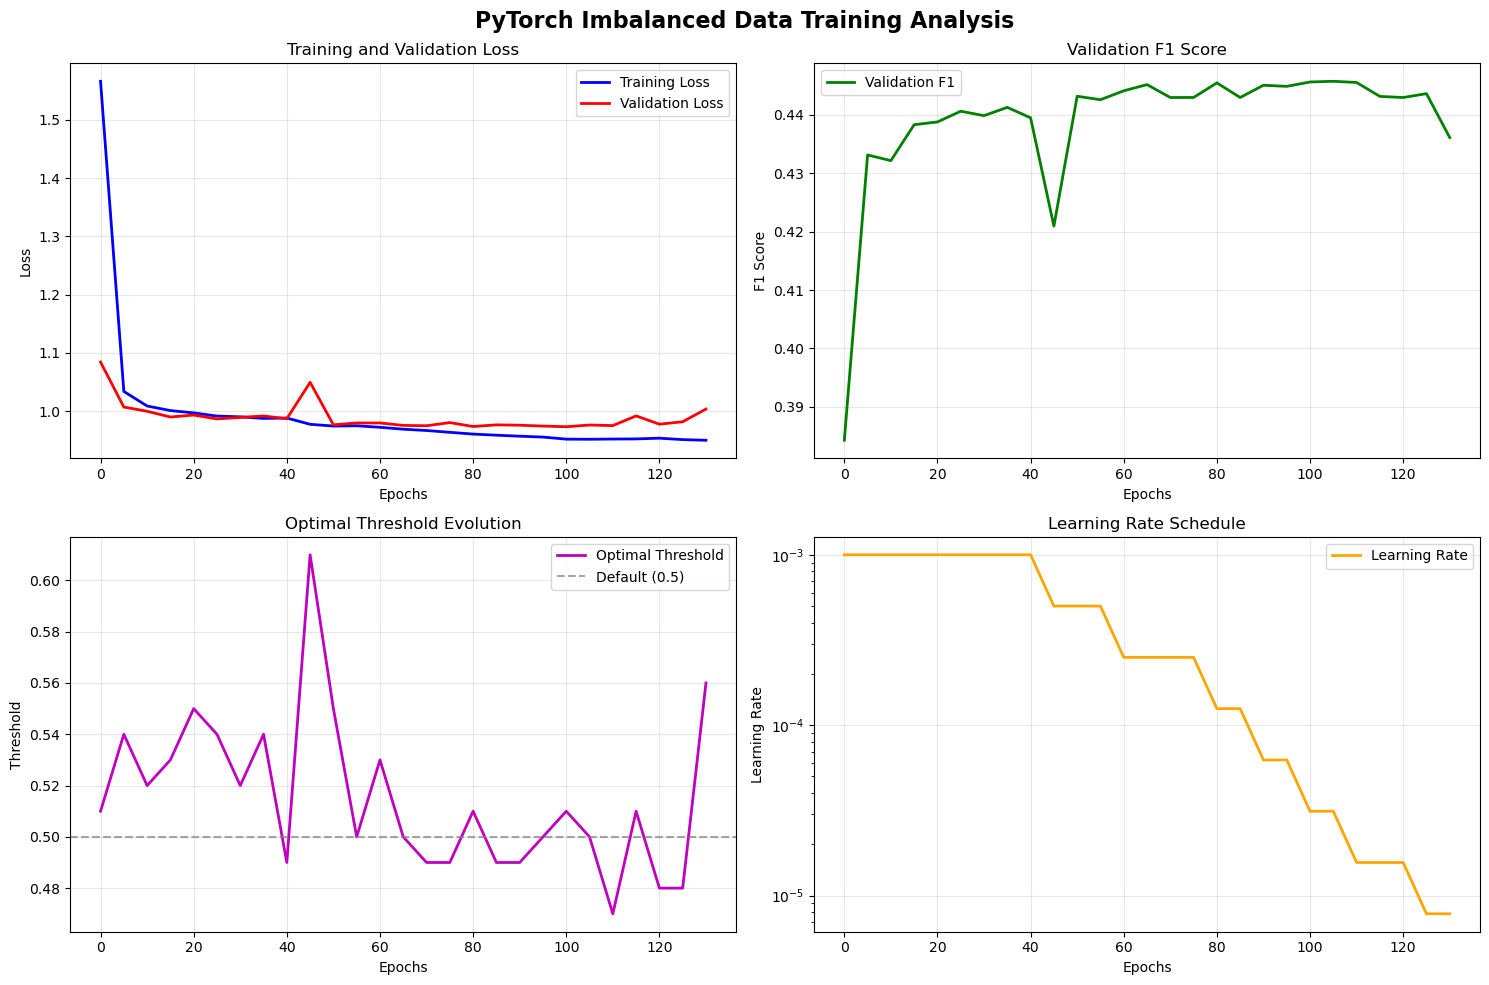

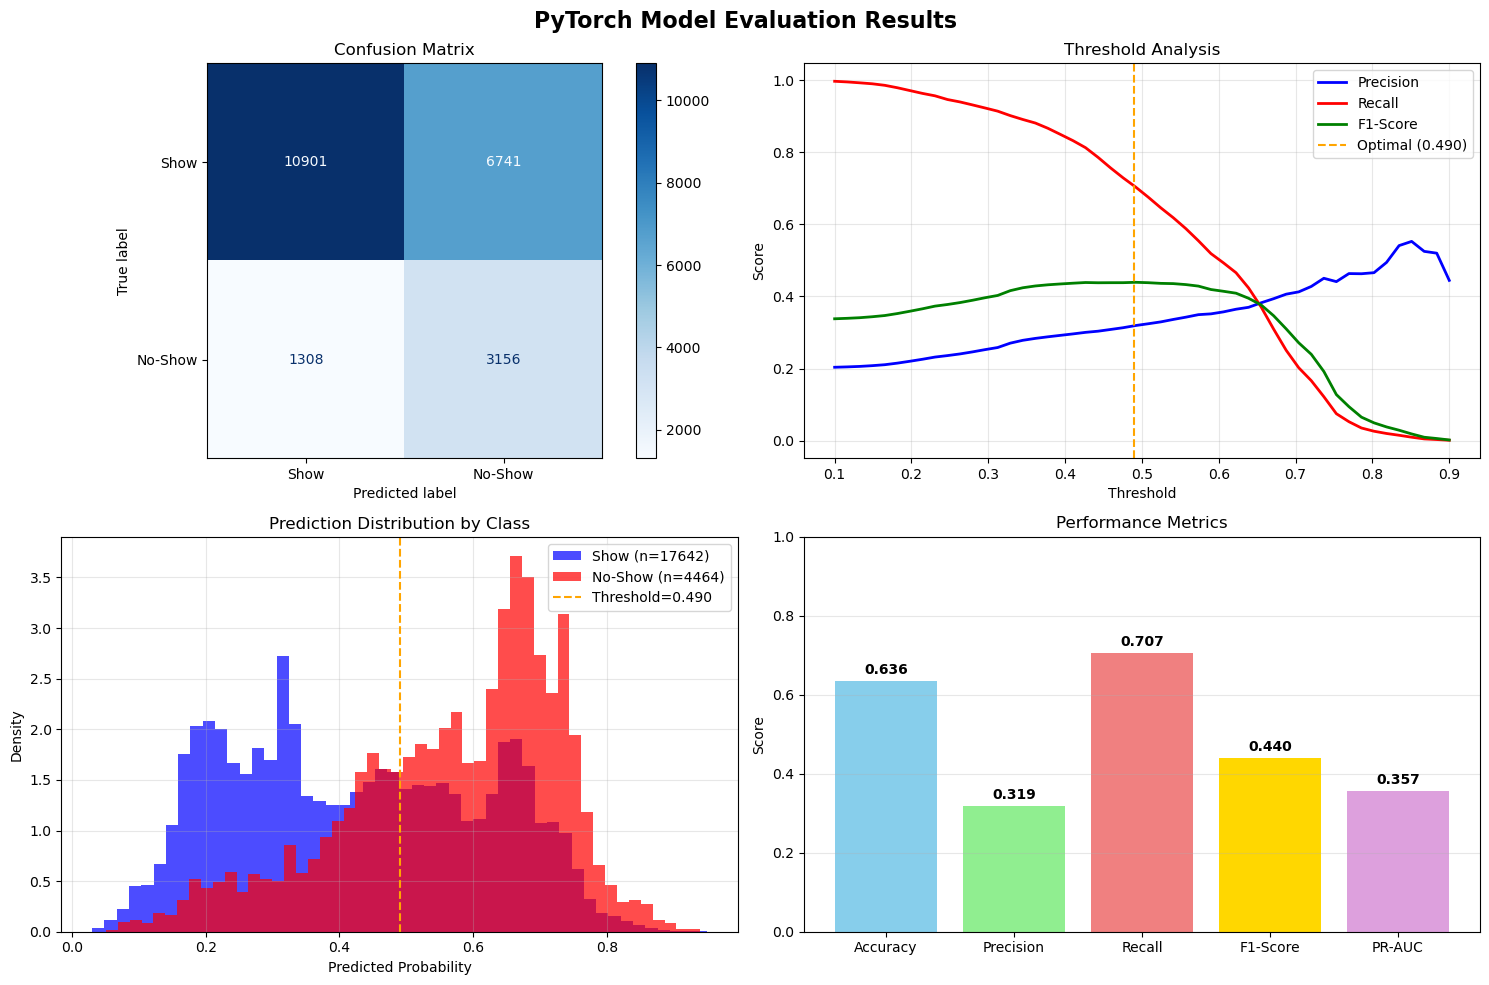

Results saved to 'pytorch_imbalanced_results.json'
Model saved as 'best_imbalanced_model.pth'


In [20]:
# =============================================================================
# Main Execution Pipeline
# =============================================================================

def main():
    """Main execution pipeline following PDF requirements"""
    print("="*80)
    print("PYTORCH NEURAL NETWORK FOR IMBALANCED MEDICAL DATASET")
    print("Following PDF Guidelines - No Oversampling/Undersampling")
    print("="*80)
    
    # 1. Load and prepare data
    print("\n1. Loading and preprocessing data...")
    X, y, feature_names = load_data()
    print(f"Dataset shape: {X.shape}")
    print(f"Class distribution: Show={np.sum(y==0)} ({np.mean(y==0):.1%}), "
          f"No-Show={np.sum(y==1)} ({np.mean(y==1):.1%})")
    
    # 2. Split data
    X_train, X_temp, y_train, y_temp = train_test_split(
        X, y, test_size=0.4, stratify=y, random_state=42
    )
    X_val, X_test, y_val, y_test = train_test_split(
        X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42
    )
    
    # 3. Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)
    X_test = scaler.transform(X_test)
    
    print(f"Training set: {X_train.shape[0]} samples")
    print(f"Validation set: {X_val.shape[0]} samples")
    print(f"Test set: {X_test.shape[0]} samples")
    
    # 4. Create data loaders
    batch_size = 64
    train_dataset = NoShowDataset(X_train, y_train)
    val_dataset = NoShowDataset(X_val, y_val)
    test_dataset = NoShowDataset(X_test, y_test)
    
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    # 5. Calculate class weights for imbalanced data (following PDF guidelines)
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )
    pos_weight = torch.tensor([class_weights[1] / class_weights[0]], dtype=torch.float32).to(DEVICE)
    
    print(f"\nClass weights: {class_weights}")
    print(f"Positive weight tensor: {pos_weight.item():.3f}")
    
    # 6. Initialize model and loss function
    print("\n2. Initializing model and loss function...")
    model = ImbalancedMLP(input_size=X_train.shape[1]).to(DEVICE)
    
    # Use weighted BCE loss (following PDF constraints)
    criterion = WeightedBCELoss(pos_weight=pos_weight)
    
    # Alternative: Use Focal Loss
    # criterion = FocalLoss(alpha=0.25, gamma=2.0)
    
    print(f"Model parameters: {sum(p.numel() for p in model.parameters()):,}")
    
    # 7. Train model
    print("\n3. Training model...")
    history, training_time = train_model(
        model, train_loader, val_loader, criterion, DEVICE,
        lr=1e-3, epochs=200, patience=25
    )
    
    print(f"Training completed in {training_time:.2f} seconds")
    
    # 8. Evaluate model
    print("\n4. Evaluating model...")
    test_results = evaluate_model(model, test_loader, DEVICE)
    
    # 9. Memory analysis
    print("\n5. Memory analysis...")
    memory_stats = analyze_memory_usage(model)
    
    # 10. Results summary
    print("\n" + "="*80)
    print("FINAL RESULTS SUMMARY")
    print("="*80)
    print(f"Accuracy: {test_results['accuracy']:.4f}")
    print(f"F1-Score: {test_results['f1_score']:.4f}")
    print(f"Precision: {test_results['precision']:.4f}")
    print(f"Recall: {test_results['recall']:.4f}")
    print(f"PR-AUC: {test_results['pr_auc']:.4f}")
    print(f"Optimal Threshold: {test_results['optimal_threshold']:.4f}")
    print(f"Training Time: {training_time:.2f} seconds")
    print(f"Model Parameters: {memory_stats['model_parameters']:,}")
    print(f"Model Size: {memory_stats['model_size_mb']:.2f} MB")
    print(f"System Memory: {memory_stats['system_memory_mb']:.1f} MB")
    
    print("\nConfusion Matrix:")
    print(test_results['confusion_matrix'])
    
    print("\nClassification Report:")
    print(test_results['classification_report'])
    
    # 11. Visualizations
    print("\n6. Generating visualizations...")
    plot_training_history(history)
    plot_evaluation_results(test_results)
    
    # 12. Save results
    results_dict = {
        'accuracy': float(test_results['accuracy']),
        'f1_score': float(test_results['f1_score']),
        'precision': float(test_results['precision']),
        'recall': float(test_results['recall']),
        'pr_auc': float(test_results['pr_auc']),
        'confusion_matrix': test_results['confusion_matrix'].tolist(),
        'optimal_threshold': float(test_results['optimal_threshold']),
        'training_time': training_time,
        'convergence_epochs': len(history['epochs']),
        'model_parameters': memory_stats['model_parameters'],
        'model_size_mb': memory_stats['model_size_mb'],
        'system_memory_mb': memory_stats['system_memory_mb'],
        'timestamp': datetime.now().isoformat(),
        'device': str(DEVICE)
    }
    
    with open('pytorch_imbalanced_results.json', 'w') as f:
        json.dump(results_dict, f, indent=2)
    
    print("Results saved to 'pytorch_imbalanced_results.json'")
    print("Model saved as 'best_imbalanced_model.pth'")
    
    return model, history, test_results, memory_stats

if __name__ == "__main__":
    model, history, results, memory_stats = main()